# HACKtheMACHINE Data Science and the Seven Seas: Collision Avoidance

This notebook provides some introductory examples to get you started with the AIS data

<font size="4.5">  Jupyter Notebook brought to you by</font>

<img src="Booz_Allen_logo_black_LARGE.jpg" width="250" height="500" img style="float: left">  
&nbsp;

<font size="3"> For questions email jarrett_jillian@bah.com</font>

### Below is some code to help you get started

In [24]:
# import dependencies

import os, io, requests, zipfile
import itertools
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from geopy.distance import great_circle
plt.rcParams['figure.figsize'] = 10,6
import warnings
warnings.filterwarnings("ignore")

## Load the data

Below is a function that inputs year, month, and zone, and returns a pandas dataframe corresponding to your inputs. In this notebook we are working with the Jan 2017 Zone 11 dataset.
Data can also be manually downloaded [here](https://marinecadastre.gov/ais/).

In [25]:
"""The data files are very large. It is normal for the download to take a few minutes"""

def download_ais_data(year, month, zone, data_dir='./data'):
    '''function to download ais data from https://marinecadastre.gov/ais/ 
    and return corresponding pandas dataframe'''
    
    # create data directory
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # create path to csv file
    csv_file = 'AIS_{}_{}_Zone{}.csv'.format(year, str(month).zfill(2), str(zone).zfill(2))
    csv_path = os.path.join(data_dir, 'AIS_ASCII_by_UTM_Month', str(year), csv_file)
        
    try:
        # read csv if already downloaded
        data = pd.read_csv(csv_path)
    except:
        # create zip file url
        zip_file_url = ('https://coast.noaa.gov/htdata/CMSP/AISDataHandler/'
                        '{}/AIS_{}_{}_Zone{}.zip'.format(year, year, 
                                                         str(month).zfill(2), 
                                                         str(zone).zfill(2)))
        # download and extract data
        r = requests.get(zip_file_url, stream=True)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(data_dir)

        # load csv as dataframe
        data = pd.read_csv(csv_path)

    return data

df = download_ais_data(2017,6,11)
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,338108787,2017-06-01T00:00:00,34.40449,-119.69123,0.0,63.1,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338067800,2017-06-01T00:00:26,33.98221,-118.45072,0.0,-133.4,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,338131199,2017-06-01T00:00:07,33.75583,-118.11642,0.0,-78.8,511.0,NaN,NaN,NaN,NaN,undefined,NaN,NaN,NaN,NaN
3,338103724,2017-06-01T00:00:46,32.71513,-117.56661,10.0,88.6,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,338092107,2017-06-01T00:00:59,33.72581,-118.07638,0.0,57.1,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## What is this data?
Luckily, we have been provided a data dictionary that explains what these columns are.



| COLUMN       | DESCRIPTION                                                                                                                                                                    |
|--------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| MMSI         | A series of nine digits uniquely identifying ship stations                                                                                                                     |
| BaseDateTime | Timestamp – Coordinated Universal Time (UTC) time accurate to nearest second when this data was generated                                                                      |
| LAT          | Latitude – to 1/10,000 minute                                                                                                                                                  |
| LON          | Longitude – to 1/10,000 minute                                                                                                                                                 |
| SOG          | Speed over ground – 0 to 102 knots with 0.1 knot resolution                                                                                                                    |
| COG          | Course over ground – relative to true north to 0.1 degree                                                                                                                      |
| Heading      | True Heading – 0 to 359 degrees from gyro compass                                                                                                                              |
| VesselName   | 20 characters to represent the name of the vessel                                                                                                                              |
| IMO          | IMO (International Maritime Organization) ship identification number – a seven-digit number that remains unchanged upon transfer of the ship's registration to another Country |
| CallSign     | International radio call sign – up to seven characters, assigned to the vessel by its Country of registry                                                                      |
| VesselType   | Type of ship/cargo                                                                                                                                                             |
| Status       | Navigation status – “at anchor”, “under way using engine(s)”, or “not under command”                                                                                           |
| Length       | Dimensions of ship – to nearest meter                                                                                                                                          |
| Width        | Dimensions of ship – to nearest meter                                                                                                                                          |
| Draft        | Draught of ship – 0.1 meter to 25.5 meters                                                                                                                                     |
| Cargo        | [AIS Vessel Codes](https://marinecadastre.gov/ais/AIS%20Documents/VesselTypeCodes2018.pdf)                                                                                                                                                               |

## Exploratory data analysis
Let's see what our data looks like: data types, null counts, value counts and distributions, etc. 

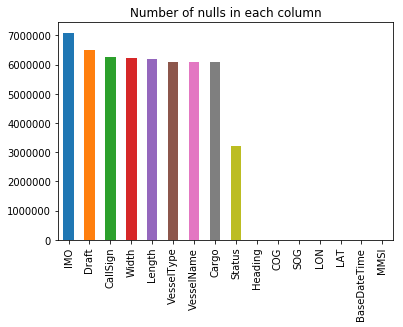

In [4]:
df.isnull().sum().sort_values(ascending=False).plot(kind='bar');
plt.title("Number of nulls in each column");

Distributions of values for the numeric columns:


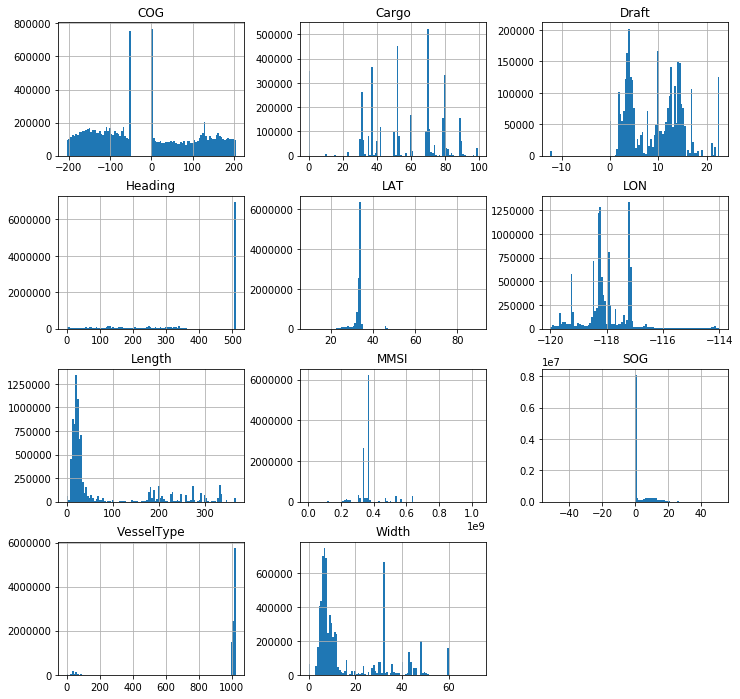

In [13]:
print("Distributions of values for the numeric columns:")
plt.rcParams['figure.figsize'] = 12,12
df.hist(bins=100)
plt.show()

You will notice that most of the headings are coded as 511, or vessel heading unavailable and that there are a lot of null values in the data. Not every field is required in an AIS transmission.

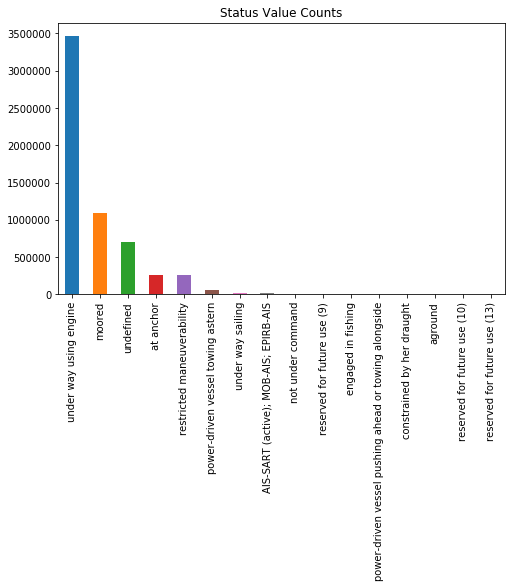

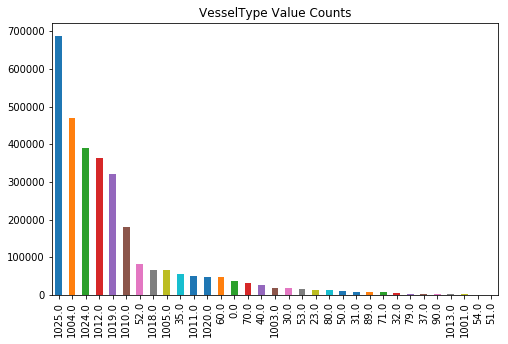

In [6]:
plt.rcParams['figure.figsize'] = 8,5
for col in ['Status','VesselType']:
    df[col].value_counts().plot(kind='bar')
    plt.title(str(col)+ " Value Counts")
    plt.show()

### Using the link in our data dictionary ([AIS Vessel Codes](https://marinecadastre.gov/ais/AIS%20Documents/VesselTypeCodes2018.pdf)), we noticed that a lot of these Vessel Types are tug tow boats. Tugs are unlikely to be involved in COLREGS interactions. Other ship types that are most likely not COLREGS interactions are offshore supply vessels. It may be helpful to cross reference vessels with sites like https://www.marinetraffic.com/

In [27]:
print("Length before dropping tug boats: {}".format(df.shape[0]))

tug_tows = [21,22,31,32,52,1023,1025] #VesselTypes that are actually tug boats
df = df[~df.VesselType.isin(tug_tows)]

print("Length after dropping tug boats: {}".format(df.shape[0]))

Length before dropping tug boats: 11341146
Length after dropping tug boats: 10019514


### In order to find COLREGS interactions we need to identify times and places where ships were in close proximity.  There is too much data to run an analysis. One way to reduce the datasize is to subset the data by geography and time. 
Here, we're filtering on the `BaseDateTime` field.

In [28]:
#Converting the BasDateTime column to a datetime datatype and adding a date column
df.BaseDateTime = pd.to_datetime(df.BaseDateTime, errors='raise')
df['date'] = df.BaseDateTime.apply(lambda x: x.date())

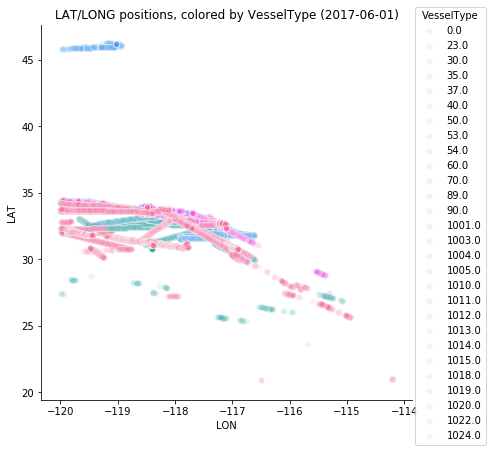

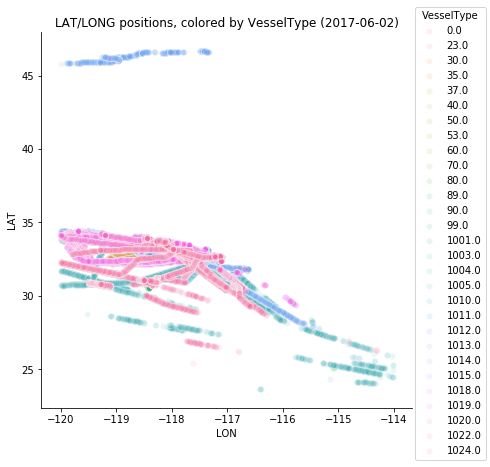

In [29]:
for i in sorted(df.date.unique())[:2]: #looking at 2 days (one at a time)
    day_df = df[df.date==i]
    sns.pairplot(x_vars=["LON"], y_vars=["LAT"], data=day_df,  hue="VesselType", size=6, plot_kws={'alpha':0.1})
    plt.title("LAT/LONG positions, colored by VesselType ("+str(day_df.date.values[0])+")")
    plt.show()

While the plots above show that there are definitely vessels close in space, we need to verify that they are also close in time. 

## Here is one brute force method to finding close encounters. It is inefficient and part of the HACKtheMACHINE challenge is finding better methods to screen for COLREGs interactions. 
This method is slow, so we drop nulls and subsetting to small fraction of the dataset as a proof of concept. 

As a starting point 8000 yards is the farthest distance relevant to COLREGS interactions. In this example

In [30]:
interval = 150  #time interval (seconds) 
distance = 24000 #24,000feet = 8000 yards 
neighbor_vessels = pd.DataFrame(columns= df.columns)

df1 = df.sort_values(by='BaseDateTime', ascending=True) #this is the dataframe to look for matches within
df1 = df1.dropna(how='any') 
df1 = df1.iloc[:2000] #subsetting to 2000 rows for proof of concept

for i,v in enumerate(df1.BaseDateTime.values): 
    
    df2 = df1.iloc[i+1:,] #removing rows we've already iterated through
    time_min = v - pd.Timedelta(seconds=interval)
    time_max = v + pd.Timedelta(seconds=interval) 
    temp_df = df2[(df2.BaseDateTime > time_min)&(df2.BaseDateTime < time_max)] #makes temp df of datapoints close in time
    
    #getting data into format to use geopy distance calculator
    temp_df['latlon'] = list(zip(temp_df.LAT, temp_df.LON)) 
    temp_df['dist'] = temp_df['latlon'].apply(lambda x: great_circle(temp_df.latlon.values[0], x).feet) #calc distances from row 0
    
    closers = temp_df[(np.abs(temp_df.dist) < distance)] #filter points close in time
    closers = closers.drop_duplicates(subset ='MMSI') #drop duplicates (same boat)
    
    if len(closers) > 1: #if closers includes more than one boat
        neighbor_vessels = neighbor_vessels.append(closers)
        
neighbor_vessels.head()

,BaseDateTime,COG,CallSign,Cargo,Draft,Heading,IMO,LAT,LON,Length,MMSI,SOG,Status,VesselName,VesselType,Width,date,dist,latlon
2316,2017-06-01 00:00:01,23.4,9HA3439,79.0,13.3,24.0,IMO9576973,33.74308,-118.27521,199.90,229603000,5.7,under way using engine,KIRAN ISTANBUL,1004.0,32.32,2017-06-01,0.000000,"(33.74308, -118.27521000000002)"
1926,2017-06-01 00:00:03,-163.3,VRBH3,70.0,12.6,71.0,IMO9224312,33.73055,-118.25333,259.80,477014500,0.0,under way using engine,SEASPAN CHIWAN,1004.0,32.35,2017-06-01,8059.580726,"(33.73055, -118.25333)"
2462,2017-06-01 00:00:05,-196.6,WSCJ,70.0,9.8,511.0,IMO7390105,33.74395,-118.22727,208.72,368850000,0.0,under way using engine,CAPE INSCRIPTION,1004.0,31.09,2017-06-01,14546.257626,"(33.74395, -118.22726999999999)"
1734,2017-06-01 00:00:12,3.9,A8TA2,70.0,14.5,196.0,IMO9465095,33.76351,-118.27234,332.58,636091803,0.0,moored,NORTHERN JAVELIN,1004.0,43.32,2017-06-01,7503.801641,"(33.76351, -118.27233999999999)"
365,2017-06-01 00:00:16,44.2,VRMC9,79.0,10.5,128.0,IMO9610717,33.74455,-118.20943,54.83,477195800,0.0,moored,JAMAICA BAY,1004.0,30.04,2017-06-01,19961.766351,"(33.74455, -118.20943)"


In [31]:
#How many close encounters have we found?
neighbor_vessels.shape

(17568, 19)

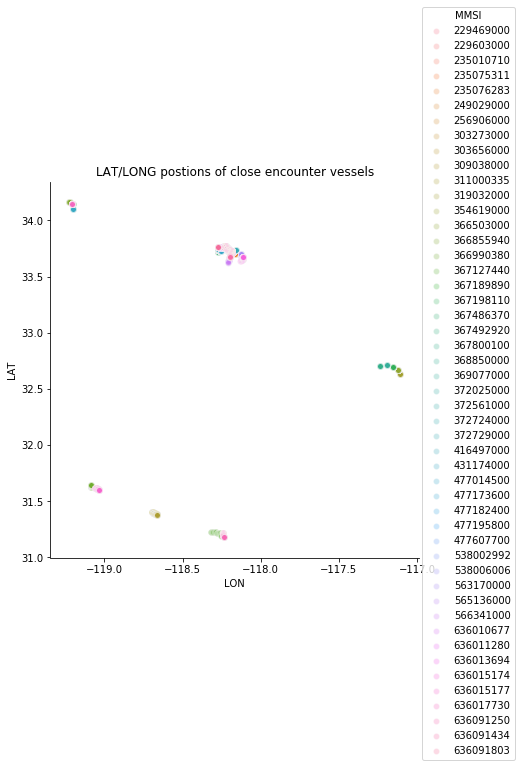

In [32]:
sns.pairplot(x_vars=["LON"], y_vars=["LAT"], data=neighbor_vessels,  hue="MMSI", size=6, plot_kws={'alpha':0.25})
plt.title("LAT/LONG postions of close encounter vessels")
plt.show()

### Visualizing the geographic data: let's see where these vessels are!
Though not used in the examples below, consider using [geopandas](http://geopandas.org/) for working with geospatial data or you can move your data into the ESRI platform for more geospatial analysis tools.

Clusters of interactions may represent ports and would likely not be relevant for COLREGs

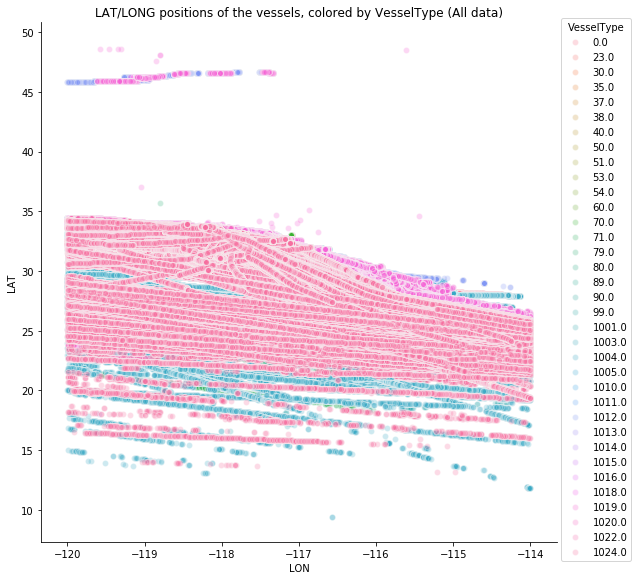

In [33]:
sns.pairplot(x_vars=["LON"], y_vars=["LAT"], data=df,  hue="VesselType", 
             size=8, plot_kws={'alpha':0.25})
plt.title("LAT/LONG positions of the vessels, colored by VesselType (All data)")
plt.show()

## This notebook is meant to serve as a jumping off point do not be constrained by these methods
From here you may want to:
1) Filter for vessels that are moving
2) Look for changes in direction or speed when vessels approach each other
3) Further explore vessel types and characterized their interactions
4) Explore the tracks of specific vessels
5) Relate vessel behavior to maritime charts


<font size="4.5">  Jupyter Notebook brought to you by</font>

<img src="Booz_Allen_logo_black_LARGE.jpg" width="250" height="500" img style="float: left">  
&nbsp;

<font size="3"> For questions email jarrett_jillian@bah.com</font>